# Q-Learning on Taxi-v3 Environment

This notebook shows **Q-learning** applied to the Taxi-v3 environment from Gymnasium.  
I will demosntrate how different **exploration strategies** affect learning:
- High exploration (epsilon=0.9)
- Low exploration (epsilon=0.1)
- Epsilon decay (from 1.0 to 0.05)

We also visualize the **learned policies** and animate the agent’s actions.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import gymnasium as gym

from IPython.display import display, clear_output

## Environment Setup

- I used `Taxi-v3`, a 5x5 grid world with a taxi, passengers, and destinations.
- `set_seed` ensures **reproducibility** of results.
- I printed the **size of the state and action spaces**.


In [2]:
env=gym.make("Taxi-v3", render_mode="ansi")
state_space=env.observation_space.n
action_space=env.action_space.n

def set_seed(env,seed=42):
    np.random.seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)

print(f"State space: {state_space}, Action space : {action_space}")


State space: 500, Action space : 6


## Q-Learning Implementation

- `choose_action`: Implements **epsilon-greedy policy**.
- `train_q_learning`: Trains a Q-table using the **Q-learning algorithm**.
- Parameters:
  - `alpha`: learning rate
  - `gamma`: discount factor
  - `epsilon`: exploration probability
  - `epsilon_decay`: optional decay factor
- Logs the **average reward** every `log_every` episodes.


In [3]:
def choose_action(state, Q,epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

In [4]:
def train_q_learning(env, alpha=0.1, gamma=0.99, epsilon=0.1,episodes=1000, epsilon_decay=None,epsilon_min=0.05, log_every=100, seed=None):
    if seed is not None:
        set_seed(env,seed)
    
    Q=np.zeros((env.observation_space.n, env.action_space.n))
    rewards=[]
    eps=epsilon

    for ep in range(episodes):
        state,_=env.reset()
        done=False
        total_reward=0

        while not done:
            if np.random.rand()<eps:
                action=env.action_space.sample()
            else:
                action=np.argmax(Q[state])
            
            next_state,reward,terminated,truncated,_=env.step(action)
            done=terminated or truncated
    
            Q[state,action]+=alpha*(reward+gamma*np.max(Q[next_state])-Q[state,action])
            state=next_state
            total_reward+=reward

        rewards.append(total_reward)
        if epsilon_decay is not None:
            eps=max(epsilon_min,eps*epsilon_decay)
        if (ep+1)%log_every==0:
            avg_last=np.mean(rewards[-log_every:])
            print(f"Episode {ep+1}/{episodes} | Avg reward (last {log_every}): {avg_last:.2f} | eps={eps:.3f}")
        
    return Q, rewards

# Training Q-Learning Agents with Different Exploration Strategies

I trained three Q-learning agents with different ε-greedy exploration strategies:

1. **High Exploration (ε=0.9):** Mostly random actions, encourages exploring the environment.  
2. **Low Exploration (ε=0.1):** Mostly follows the current Q-values, less exploration.  
3. **Epsilon Decay (ε starts at 0.1 → 0.05):** Starts with some exploration and gradually exploits more.

For each episode:
- The agent chooses an action based on ε-greedy policy.  
- Q-values are updated using the Q-learning formula.  
- Rewards are recorded.

The log prints the **average reward over the last 100 episodes**, showing how the agent improves during the training-process.


In [5]:
episodes=2000
seed=42

print("High Exploration")
Q_explore,rewards_explore=train_q_learning(env,epsilon=0.9,episodes=episodes,seed=seed)
print("Low Exploration")
Q_exploit,rewards_exploit=train_q_learning(env,epsilon=0.1,episodes=episodes,seed=seed)
print("Epsilon Decay 1.0->0.05")
Q_decay,rewards_decay=train_q_learning(env,epsilon=0.1,epsilon_decay=0.995,epsilon_min=0.05,episodes=episodes,seed=seed)

High Exploration
Episode 100/2000 | Avg reward (last 100): -684.32 | eps=0.900
Episode 200/2000 | Avg reward (last 100): -691.66 | eps=0.900
Episode 300/2000 | Avg reward (last 100): -682.62 | eps=0.900
Episode 400/2000 | Avg reward (last 100): -654.88 | eps=0.900
Episode 500/2000 | Avg reward (last 100): -642.85 | eps=0.900
Episode 600/2000 | Avg reward (last 100): -618.09 | eps=0.900
Episode 700/2000 | Avg reward (last 100): -628.34 | eps=0.900
Episode 800/2000 | Avg reward (last 100): -621.68 | eps=0.900
Episode 900/2000 | Avg reward (last 100): -552.93 | eps=0.900
Episode 1000/2000 | Avg reward (last 100): -546.07 | eps=0.900
Episode 1100/2000 | Avg reward (last 100): -560.65 | eps=0.900
Episode 1200/2000 | Avg reward (last 100): -573.86 | eps=0.900
Episode 1300/2000 | Avg reward (last 100): -536.57 | eps=0.900
Episode 1400/2000 | Avg reward (last 100): -521.47 | eps=0.900
Episode 1500/2000 | Avg reward (last 100): -530.65 | eps=0.900
Episode 1600/2000 | Avg reward (last 100): -528

## Smoothed Reward Comparison

- We visualize the **learning progress** of each strategy.
- The moving average helps **smooth out the fluctuations** in rewards.
- This plot shows how quickly each strategy learns to maximize its rewards.


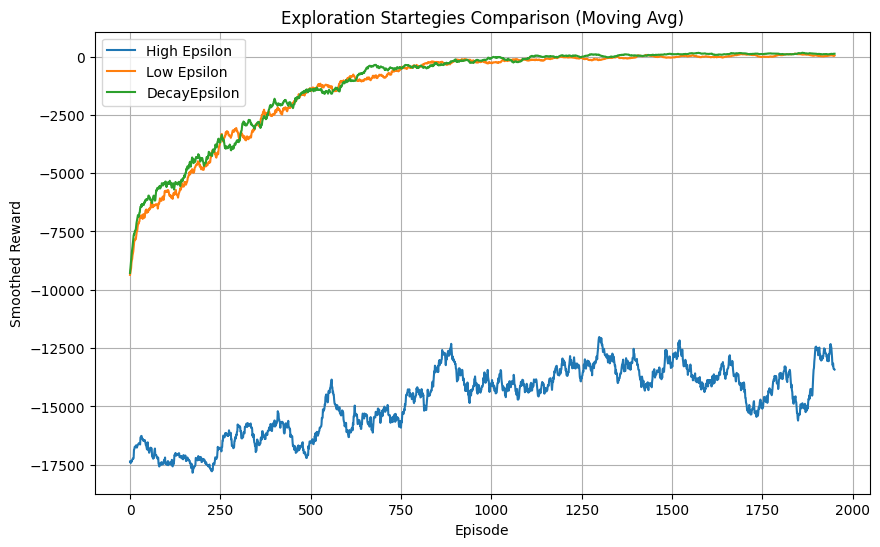

In [6]:
def moving_avg(x,w=50):
    return np.convolve(x,np.ones(w)/2,mode="valid")
plt.figure(figsize=(10,6))
plt.plot(moving_avg(rewards_explore),label="High Epsilon")
plt.plot(moving_avg(rewards_exploit),label="Low Epsilon")
plt.plot(moving_avg(rewards_decay),label="DecayEpsilon")

plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.title("Exploration Startegies Comparison (Moving Avg)")
plt.legend()
plt.grid(True)
plt.show()

## Learned Policy Visualization

- Displays the **optimal action** at each grid cell for a fixed passenger and destination.
- Symbols:
  - ↓, ↑, →, ←: taxi movement
  - P: pick up
  - D: drop off
- Here we visualize the **policy learned with epsilon decay**.


In [7]:
def plot_policy(Q,passenger,destination,title_suffix=""):

    grid_size=5
    action_symbols=['↓', '↑', '→', '←', 'P', 'D']
    
    policy_grid=np.empty((grid_size,grid_size),dtype=object)
    passenger=0
    destination=1
    
    for row in range(grid_size):
        for col in range(grid_size):
            state=env.unwrapped.encode(row,col,passenger,destination)
            best_action=np.argmax(Q_decay[state])
            policy_grid[row,col]=action_symbols[best_action]
    
    
    fig,ax=plt.subplots(figsize=(6,6))
    ax.imshow(np.zeros((grid_size,grid_size)),cmap="Pastel1")
    for x in range(grid_size):
        for y in range(grid_size):
            ax.text(y,x,policy_grid[x,y],ha="center",va="center",fontsize=16)
    
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_yticklabels(range(grid_size))
    ax.set_xticklabels(range(grid_size))
    ax.set_title("Learned Taxi Policy (Passenger=0, Destination=1)")
    plt.show()


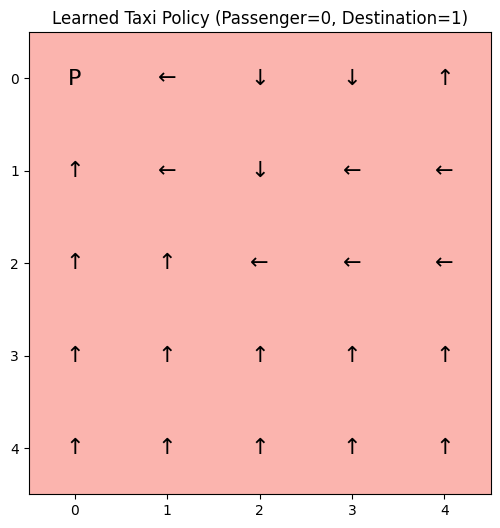

In [8]:
plot_policy(Q_decay,passenger=0,destination=1,title_suffix="-epsilon decay")

## Policy Evaluation and Animation

- Evaluates **one episode** using each learned policy.
- **Animation** (text-based) shows the taxi moving in the grid.
- Compares **steps and total reward** to see which strategy is most efficient.



In [9]:
def evaluate_policy(env, Q, max_steps=200, animate=True, title=""):
    # Fixed start positions
    passenger=0
    destination=0
    taxi_pos=(0, 0)

    state, info=env.reset(
        options={"passenger_location": passenger,
                 "destination": destination,
                 "taxi_position": taxi_pos}
    )

    done=False
    steps=0
    total_reward=0
    frames=[]

    while not done and steps < max_steps:
        action=np.argmax(Q[state])
        state, reward, terminated, truncated, info = env.step(action)
        done=terminated or truncated
        total_reward+=reward
        steps+=1

        if animate:
            frames.append(env.render())

    print(f"{title} | Steps: {steps} | Total reward: {total_reward}")

    if animate:
        for frame in frames:
            clear_output(wait=True)
            print(title)
            print(frame)
            time.sleep(0.25)

    return steps, total_reward


In [10]:
steps_high, r_high=evaluate_policy(env, Q_explore,animate=True, title="High Exploration Policy")

steps_low, r_low=evaluate_policy(env, Q_exploit,animate=True, title="Low Exploration Policy")

steps_decay, r_decay=evaluate_policy(env, Q_decay,animate=True, title="Epsilon Decay Policy")


Epsilon Decay Policy
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [11]:
print("\nComparison of learned policies:")
print(f"High exploration  -> steps: {steps_high}, reward: {r_high}")
print(f"Low exploration   -> steps: {steps_low},  reward: {r_low}")
print(f"Epsilon decay     -> steps: {steps_decay}, reward: {r_decay}")


Comparison of learned policies:
High exploration  -> steps: 17, reward: 4
Low exploration   -> steps: 17,  reward: 4
Epsilon decay     -> steps: 14, reward: 7


# Comparison of Learned Policies

After evaluation, we summarize:

| Strategy          | Steps | Reward |
|------------------|-------|--------|
| High Exploration  | 17    | 4      |
| Low Exploration   | 17    | 4      |
| Epsilon Decay     | 14    | 7      |

- **Steps:** Number of moves taken to deliver the passenger.  
- **Reward:** Total reward for the episode (higher is better).  

**Observation:**  
- Even if training rewards were negative for high exploration, the final policy can still perform well.  
- Epsilon decay usually gives the best combination of short path (few steps) and high reward.
